## Calculate distance between means/medoids of mutation groupings

Our goal is to find an unsupervised way of calculating distance/similarity between our mutation groupings ("none"/"one"/"both") which isn't affected by sample size, to the degree that differentially expressed gene count was (see `4_de_analysis` notebooks).

Here, we'll try the extremely simple method of:

1) taking the n-dimensional mean (centroid) or median (medoid) of each group  
2) calculating distance between the centroids and using this to define "expression similarity"

We'll try this for a few different feature selection/embedding methods, and for both gene expression and RPPA (protein expression) data.

In [1]:
from pathlib import Path
import pickle as pkl
import itertools as it

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys; sys.path.append('..')
import config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
# whether to use expression or rppa data
# data_type = 'expression'
data_type = 'rppa'

# how to calculate centroids, 'mean' or 'median'
centroid_method = 'median'

# preprocessing method, 'none' or 'pca' currently
preprocessing = 'none'
# preprocessing = 'pca'

# number of features to subset to, by mean absolute deviation
# TODO try this in PCA/UMAP space too
subset_feats = None
# subset_feats = 105

### Load expression data

We'll also subset to the top features by mean absolute deviation, if that option .

In [3]:
expression_data_file = (
    '/home/jake/research/mpmp/data/tcga_expression_matrix_processed.tsv.gz'
)

rppa_data_file = (
    '/home/jake/research/mpmp/data/tcga_rppa_matrix_processed.tsv'
)

if data_type == 'expression':
    data_df = pd.read_csv(expression_data_file, sep='\t', index_col=0)
elif data_type == 'rppa':
    data_df = pd.read_csv(rppa_data_file, sep='\t', index_col=0)
    
print(data_df.shape)
data_df.iloc[:5, :5]

(7790, 189)


,X1433EPSILON,X4EBP1,X4EBP1_pS65,X4EBP1_pT37T46,X53BP1
sample_id,,,,,
TCGA-OR-A5J2-01,-0.494,0.592,0.10500,-0.13500,1.89
TCGA-PA-A5YG-01,-0.535,0.183,-0.10600,-0.04010,1.03
TCGA-OR-A5JV-01,-0.109,0.418,0.02470,-0.72100,1.66
TCGA-OR-A5JT-01,-0.413,0.259,0.00597,0.56300,1.46
TCGA-OR-A5JR-01,-0.288,-0.112,0.01940,-0.00267,2.23


In [4]:
# if PCA preprocessing is selected, convert raw features to PCs
# select the number of PCs using subset_feats
if preprocessing == 'pca':
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # standardize features first
    data_df = pd.DataFrame(
        StandardScaler().fit_transform(data_df),
        index=data_df.index.copy(),
        columns=data_df.columns.copy()
    )
    
    # then transform using PCA
    pca = PCA(n_components=subset_feats)
    data_df = pd.DataFrame(
        pca.fit_transform(data_df),
        index=data_df.index.copy(),
        columns=['PC{}'.format(i) for i in range(subset_feats)]
    )
    
data_df.iloc[:5, :5]

,X1433EPSILON,X4EBP1,X4EBP1_pS65,X4EBP1_pT37T46,X53BP1
sample_id,,,,,
TCGA-OR-A5J2-01,-0.494,0.592,0.10500,-0.13500,1.89
TCGA-PA-A5YG-01,-0.535,0.183,-0.10600,-0.04010,1.03
TCGA-OR-A5JV-01,-0.109,0.418,0.02470,-0.72100,1.66
TCGA-OR-A5JT-01,-0.413,0.259,0.00597,0.56300,1.46
TCGA-OR-A5JR-01,-0.288,-0.112,0.01940,-0.00267,2.23


In [5]:
# if no preprocessing, subset features by mean absolute deviation
if preprocessing == 'none' and subset_feats is not None:
    mad_ranking = (
        data_df.mad(axis=0)
               .sort_values(ascending=False)
    )
    top_feats = mad_ranking[:subset_feats].index.astype(str).values
    print(top_feats[:5])
    data_df = data_df.reindex(top_feats, axis='columns')
    
print(data_df.shape)
data_df.iloc[:5, :5]

(7790, 189)


,X1433EPSILON,X4EBP1,X4EBP1_pS65,X4EBP1_pT37T46,X53BP1
sample_id,,,,,
TCGA-OR-A5J2-01,-0.494,0.592,0.10500,-0.13500,1.89
TCGA-PA-A5YG-01,-0.535,0.183,-0.10600,-0.04010,1.03
TCGA-OR-A5JV-01,-0.109,0.418,0.02470,-0.72100,1.66
TCGA-OR-A5JT-01,-0.413,0.259,0.00597,0.56300,1.46
TCGA-OR-A5JR-01,-0.288,-0.112,0.01940,-0.00267,2.23


### Load Park et al. "hit" data

This was collated/formatted in `0_process_park.ipynb`

In [6]:
with open(cfg.distance_gain_info, 'rb') as f:
    park_gain_info = pkl.load(f)
    
park_gain_info['TP53_BRCA'].head()

,class_name,mutation_status,cnv_status,num_hits
TCGA-3C-AAAU-01,class 4,0,1,one
TCGA-3C-AALI-01,class 4,1,1,both
TCGA-3C-AALJ-01,class 4,0,1,one
TCGA-3C-AALK-01,class 4,0,1,one
TCGA-4H-AAAK-01,class 4,0,1,one


In [7]:
with open(cfg.distance_loss_info, 'rb') as f:
    park_loss_info = pkl.load(f)
    
park_loss_info['TP53_BRCA'].head()

,class_name,mutation_status,cnv_status,num_hits
TCGA-3C-AAAU-01,class 4,0,0,none
TCGA-3C-AALI-01,class 4,1,0,one
TCGA-3C-AALJ-01,class 4,0,0,none
TCGA-3C-AALK-01,class 4,0,0,none
TCGA-4H-AAAK-01,class 4,0,0,none


### Calculate distance between means/medians for given gene + cancer type

In [8]:
from scipy.spatial.distance import pdist, squareform

def get_centroids_and_distance(identifier, info_df, centroid_method='mean'):
    
    groups = ['both', 'none', 'one']
    group_combinations = list(it.combinations(groups, 2))
    class_name = info_df['class_name'].values[0]
    
    # get expression data for samples
    samples = info_df.index.intersection(data_df.index)
    info_df = info_df.reindex(samples)
    
    # if one group has no samples, we have to make sure to assign it 0 count
    class_counts = []
    hit_class_counts = info_df.groupby('num_hits').count().class_name
    for group in groups:
        if group in hit_class_counts.index:
            class_counts.append(hit_class_counts[group])
        else:
            class_counts.append(0)
    
    # group by number of hits, then calculate centroids
    centroids_df = (data_df
        .reindex(samples)
        .merge(info_df['num_hits'], left_index=True, right_index=True)
        .groupby('num_hits')
    )
    
    if centroid_method == 'mean':
        centroids_df = centroids_df.mean()
    elif centroid_method == 'median':
        centroids_df = centroids_df.median()
    else:
        raise NotImplementedError(
            'centroid method {} not implemented'.format(centroid_method)
        )
    
    # calculate distance between centroids
    # make sure this is in the same order for each identifier, and
    # handle NA distances here (if one group doesn't have any samples)
    dists = pdist(centroids_df.values, metric='euclidean')
    dist_combinations = list(it.combinations(hit_class_counts.index, 2))
    ordered_dists = []
    for cmb in group_combinations:
        if cmb not in dist_combinations:
            ordered_dists.append(np.nan)
        else:
            cmb_ix = dist_combinations.index(cmb)
            ordered_dists.append(dists[cmb_ix])
    
    return (groups,
            group_combinations,
            class_counts,
            ordered_dists)
    
get_centroids_and_distance('TP53_BRCA',
                           park_loss_info['TP53_BRCA'],
                           'median')

(['both', 'none', 'one'],
 [('both', 'none'), ('both', 'one'), ('none', 'one')],
 [19, 491, 287],
 [5.4560649026605255, 2.52495957315043, 3.9882813466454436])

### Calculate centroid distance between "hits", per class

Class 1 = look at both loss and gain (should be one-hit in neither)  
Class 2 = only look at loss (should be one-hit here)  
Class 3 = only look at gain (should be one-hit here)  
Class 4 = look at both loss and gain (should be one-hit in both)

In [9]:
class_counts_df = {}
results_df = {}
class_names = {}
counts_columns = None
results_columns = None

# get distances for copy loss, for class 1/2/4 genes
for identifier, loss_df in park_loss_info.items():
    
    class_name = loss_df.head(1).class_name.values[0]
    if class_name == 'class 3':
        continue
        
    results = get_centroids_and_distance(identifier, loss_df, 'mean')
    
    if counts_columns is None:
        counts_columns = results[0]
    else:
        assert counts_columns == results[0]
        
    if results_columns is None:
        results_columns = ['{}/{}'.format(i, j) for i, j in results[1]]
            
    class_names[identifier] = class_name
    class_counts_df[identifier] = results[2]
    results_df[identifier] = results[3]
    
class_counts_loss_df = (
    pd.DataFrame(class_counts_df.values(),
                 index=class_counts_df.keys(),
                 columns=counts_columns)
      .merge(pd.Series(class_names).rename('class_name'),
             left_index=True, right_index=True)
)
    
results_loss_df = (
    pd.DataFrame(results_df.values(),
                 index=results_df.keys(),
                 columns=results_columns)
      .merge(pd.Series(class_names).rename('class_name'),
             left_index=True, right_index=True)
)
    
print(class_counts_loss_df.shape)
class_counts_loss_df.head()

(433, 4)


,both,none,one,class_name
ACVR1_UCEC,2,309,94,class 1
ACVR2A_COADREAD,3,264,96,class 1
ACVR2A_LIHC,0,134,29,class 1
AJUBA_HNSC,5,132,65,class 2
AKT1_BRCA,5,650,142,class 1


In [10]:
print(results_loss_df.shape)
results_loss_df.head()

(433, 4)


,both/none,both/one,none/one,class_name
ACVR1_UCEC,4.948054,4.221548,1.687753,class 1
ACVR2A_COADREAD,5.888766,5.641465,0.859156,class 1
ACVR2A_LIHC,NaN,NaN,1.646777,class 1
AJUBA_HNSC,2.996103,2.828437,0.992651,class 2
AKT1_BRCA,3.674103,3.341514,1.154081,class 1


In [11]:
class_counts_df = {}
results_df = {}
class_names = {}
counts_columns = None
results_columns = None

# get distances for copy gain, for class 1/3/4 genes
for identifier, gain_df in park_gain_info.items():
    
    class_name = gain_df.head(1).class_name.values[0]
    if class_name == 'class 2':
        continue
        
    results = get_centroids_and_distance(identifier, gain_df, 'mean')
    
    if counts_columns is None:
        counts_columns = results[0]
    else:
        assert counts_columns == results[0]
        
    if results_columns is None:
        results_columns = ['{}/{}'.format(i, j) for i, j in results[1]]
            
    class_names[identifier] = class_name
    class_counts_df[identifier] = results[2]
    results_df[identifier] = results[3]
    
class_counts_gain_df = (
    pd.DataFrame(class_counts_df.values(),
                 index=class_counts_df.keys(),
                 columns=counts_columns)
      .merge(pd.Series(class_names).rename('class_name'),
             left_index=True, right_index=True)
)
    
results_gain_df = (
    pd.DataFrame(results_df.values(),
                 index=results_df.keys(),
                 columns=results_columns)
      .merge(pd.Series(class_names).rename('class_name'),
             left_index=True, right_index=True)
)
    
print(class_counts_gain_df.shape)
class_counts_gain_df.head()

(384, 4)


,both,none,one,class_name
ACVR1_UCEC,0,362,43,class 1
ACVR2A_COADREAD,2,320,41,class 1
ACVR2A_LIHC,2,133,28,class 1
AKT1_BRCA,0,557,240,class 1
AKT1_UCEC,0,347,58,class 1


In [12]:
print(results_gain_df.shape)
results_gain_df.head()

(384, 4)


,both/none,both/one,none/one,class_name
ACVR1_UCEC,NaN,NaN,1.370613,class 1
ACVR2A_COADREAD,5.358835,5.140103,1.553890,class 1
ACVR2A_LIHC,3.063198,3.185015,1.361812,class 1
AKT1_BRCA,NaN,NaN,1.564338,class 1
AKT1_UCEC,NaN,NaN,1.771801,class 1


### Plot centroid distance results

To make our plots, we'll just get rid of NaN rows (i.e. genes/cancer types that don't have at least one sample in each "hit" category).

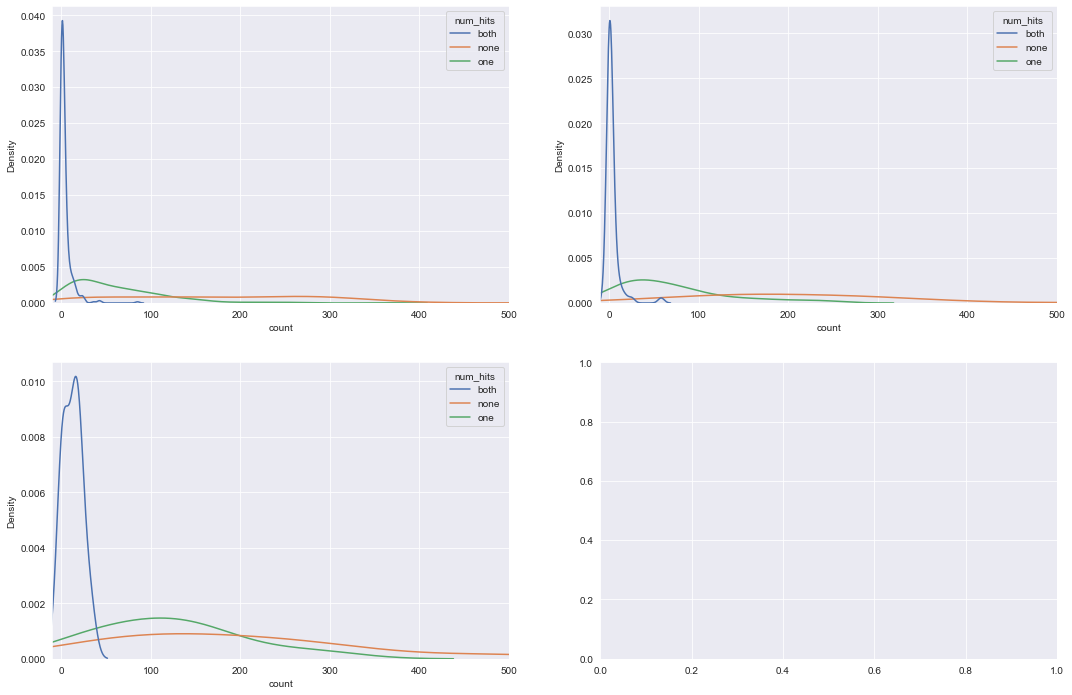

In [13]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot class counts distributions for copy loss
for ix, class_name in enumerate(['class 1', 'class 2', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (class_counts_loss_df[class_counts_loss_df.class_name == class_name]
      .drop(columns='class_name')
      .dropna(axis='index')
      .reset_index()
      .rename(columns={'index': 'identifier'})
      .melt(id_vars='identifier', value_name='count', var_name='num_hits')
    )
    sns.kdeplot(data=plot_df, x='count', hue='num_hits', ax=ax)
    ax.set_xlim(-10, 500)

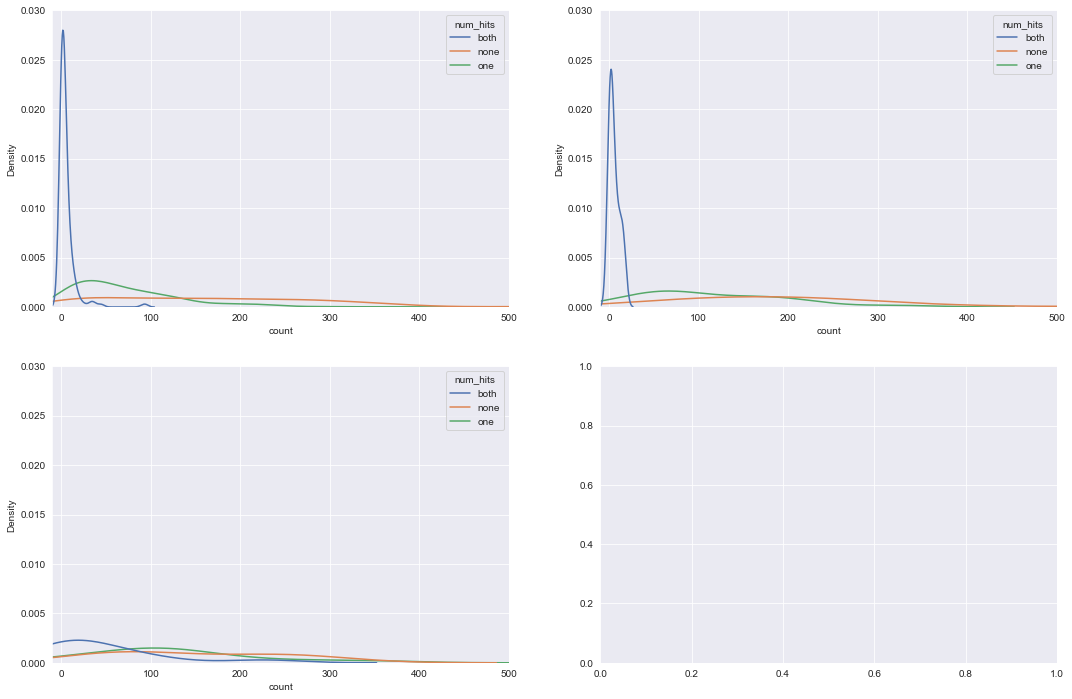

In [14]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot class counts distributions for copy gain
for ix, class_name in enumerate(['class 1', 'class 3', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (class_counts_gain_df[class_counts_gain_df.class_name == class_name]
      .drop(columns='class_name')
      .dropna(axis='index')
      .reset_index()
      .rename(columns={'index': 'identifier'})
      .melt(id_vars='identifier', value_name='count', var_name='num_hits')
    )
    sns.kdeplot(data=plot_df, x='count', hue='num_hits', ax=ax)
    ax.set_xlim(-10, 500)
    ax.set_ylim(0.0, 0.03)

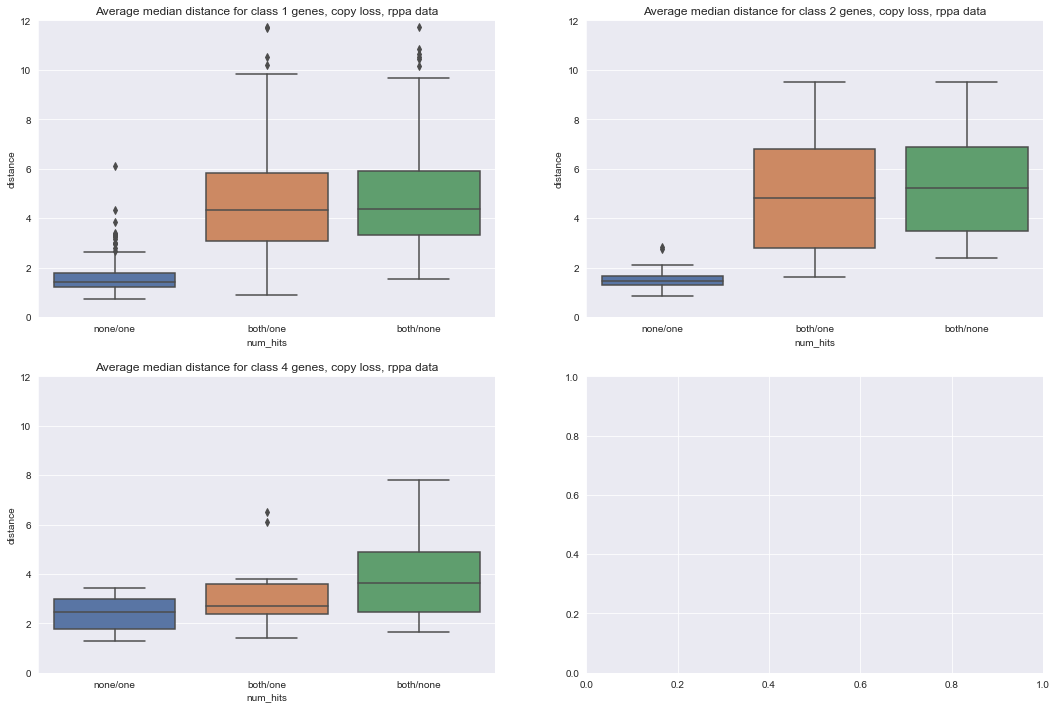

In [15]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot copy loss results here
for ix, class_name in enumerate(['class 1', 'class 2', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (
        results_loss_df[results_loss_df.class_name == class_name]
          .drop(columns='class_name')
          .dropna(axis='index')
          .reset_index()
          .rename(columns={'index': 'identifier'})
          .melt(id_vars='identifier', value_name='distance', var_name='num_hits')
    )
    sns.boxplot(data=plot_df, x='num_hits', y='distance', ax=ax,
                order=['none/one', 'both/one', 'both/none'])
    if data_type == 'rppa':
        ax.set_ylim(0, 12)
    elif preprocessing == 'pca':
        ax.set_ylim(0, 180)
    elif data_type == 'expression':
        ax.set_ylim(0, 1.75e6)
    ax.set_title('Average {} distance for {} genes, copy loss, {} data'.format(
                   centroid_method, class_name, data_type))

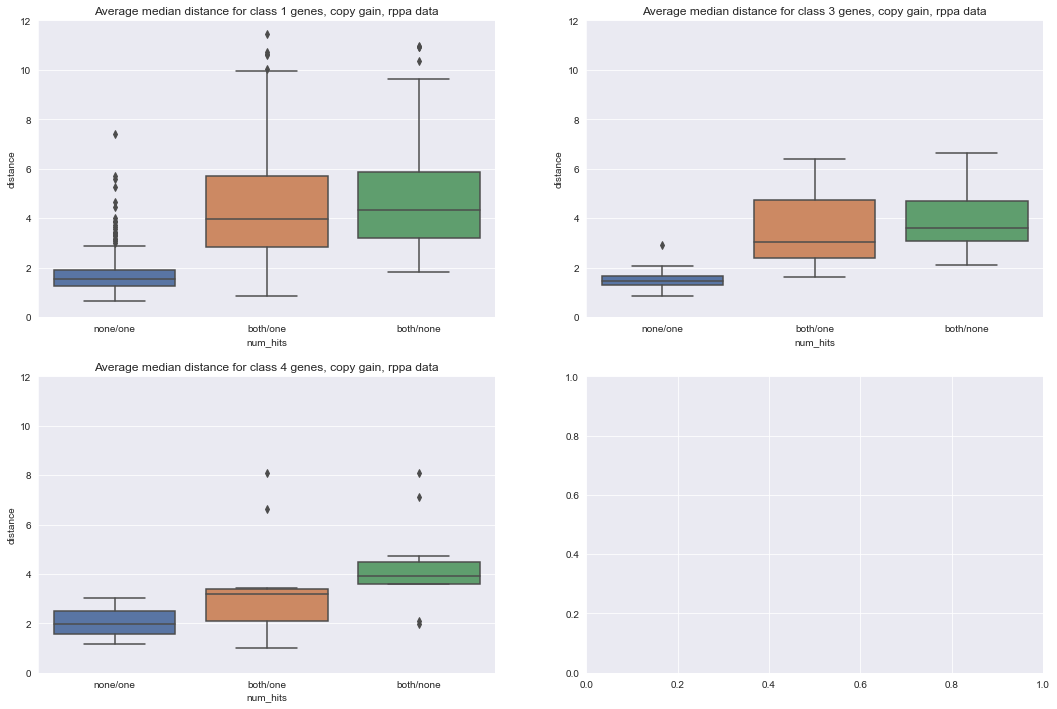

In [16]:
sns.set({'figure.figsize': (18, 12)})

fig, axarr = plt.subplots(2, 2)

# plot copy gain results here
for ix, class_name in enumerate(['class 1', 'class 3', 'class 4']):
    ax = axarr[ix // 2, ix % 2]
    # convert dataframe to long-form to plot it
    plot_df = (
        results_gain_df[results_gain_df.class_name == class_name]
          .drop(columns='class_name')
          .dropna(axis='index')
          .reset_index()
          .rename(columns={'index': 'identifier'})
          .melt(id_vars='identifier', value_name='distance', var_name='num_hits')
    )
    sns.boxplot(data=plot_df, x='num_hits', y='distance', ax=ax,
                order=['none/one', 'both/one', 'both/none'])
    if data_type == 'rppa':
        ax.set_ylim(0, 12)
    elif preprocessing == 'pca':
        ax.set_ylim(0, 140)
    elif data_type == 'expression':
        ax.set_ylim(0, 1.75e6)
    ax.set_title('Average {} distance for {} genes, copy gain, {} data'.format(
                   centroid_method, class_name, data_type))